In [156]:
# import libraries 
import pandas as pd
import numpy as np
import math
from scipy.stats import kurtosis, skew

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.metrics import r2_score, mean_squared_error

from sklearn.preprocessing import OneHotEncoder, StandardScaler, MaxAbsScaler, MinMaxScaler
from sklearn.impute import SimpleImputer

from sklearn.pipeline import Pipeline

# this will allow us to visualize the pipeline (may not be available in learn-env)
from sklearn import set_config
set_config(display= 'diagram')

from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, \
RandomizedSearchCV, StratifiedKFold, KFold
from sklearn.feature_selection import SelectFromModel

from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, \
AdaBoostClassifier, GradientBoostingClassifier

from pickle import dump, load

pd.set_option('display.max_columns', None)

np.random_state = 42

In [157]:
# load batting_basic
batting_basic = pd.read_csv('Data/batting_basic', index_col = 0)
batting_basic.head()

,Season,Name,POS,Team,Age,Salary,Adjusted 2021 Salary,G,AB,PA,AVG,H,1B,2B,3B,HR,R,RBI,BB,IBB,SO,HBP,SF,SH,GDP,SB,CS,OBP,SLG,OPS
0,2000.0,Jeff Abbott,OF,CHW,27.0,255000.0,394926.0,80.0,215.0,242.0,0.274,59.0,40.0,15.0,1.0,3.0,31.0,29.0,21.0,1.0,38.0,2.0,1.0,2.0,2.0,2.0,1.0,0.343,0.395,0.738
1,2000.0,Kurt Abbott,2B,NYM,31.0,500000.0,774365.0,79.0,157.0,173.0,0.217,34.0,20.0,7.0,1.0,6.0,22.0,12.0,14.0,2.0,51.0,1.0,1.0,0.0,2.0,1.0,1.0,0.283,0.389,0.672
2,2006.0,Reggie Abercrombie,OF,MIA,24.0,327000.0,430203.0,111.0,255.0,281.0,0.212,54.0,35.0,12.0,2.0,5.0,39.0,24.0,18.0,2.0,78.0,3.0,1.0,4.0,2.0,6.0,5.0,0.271,0.333,0.604
3,2001.0,Brent Abernathy,2B,TBR,23.0,215000.0,321031.0,79.0,304.0,335.0,0.270,82.0,59.0,17.0,1.0,5.0,43.0,33.0,27.0,1.0,35.0,0.0,1.0,3.0,3.0,8.0,3.0,0.328,0.382,0.710
4,2002.0,Brent Abernathy,2B,TBR,24.0,215000.0,317237.0,117.0,463.0,504.0,0.242,112.0,88.0,18.0,4.0,2.0,46.0,40.0,25.0,0.0,46.0,6.0,2.0,8.0,8.0,10.0,4.0,0.288,0.311,0.599


In [158]:
batting_basic.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9139 entries, 0 to 9138
Data columns (total 30 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Season                9139 non-null   float64
 1   Name                  9139 non-null   object 
 2   POS                   9139 non-null   object 
 3   Team                  9139 non-null   object 
 4   Age                   9139 non-null   float64
 5   Salary                9139 non-null   float64
 6   Adjusted 2021 Salary  9139 non-null   float64
 7   G                     9139 non-null   float64
 8   AB                    9139 non-null   float64
 9   PA                    9139 non-null   float64
 10  AVG                   9139 non-null   float64
 11  H                     9139 non-null   float64
 12  1B                    9139 non-null   float64
 13  2B                    9139 non-null   float64
 14  3B                    9139 non-null   float64
 15  HR                   

We likely dont need the following columns to determine our target variable of `Salary` so we can drop them moving forward:
- `Season`
- `Team`
- `Name`


In [159]:
batting_basic = batting_basic.drop(columns = ['Season', 'Name'])
batting_basic

,POS,Team,Age,Salary,Adjusted 2021 Salary,G,AB,PA,AVG,H,1B,2B,3B,HR,R,RBI,BB,IBB,SO,HBP,SF,SH,GDP,SB,CS,OBP,SLG,OPS
0,OF,CHW,27.0,255000.0,394926.0,80.0,215.0,242.0,0.274,59.0,40.0,15.0,1.0,3.0,31.0,29.0,21.0,1.0,38.0,2.0,1.0,2.0,2.0,2.0,1.0,0.343,0.395,0.738
1,2B,NYM,31.0,500000.0,774365.0,79.0,157.0,173.0,0.217,34.0,20.0,7.0,1.0,6.0,22.0,12.0,14.0,2.0,51.0,1.0,1.0,0.0,2.0,1.0,1.0,0.283,0.389,0.672
2,OF,MIA,24.0,327000.0,430203.0,111.0,255.0,281.0,0.212,54.0,35.0,12.0,2.0,5.0,39.0,24.0,18.0,2.0,78.0,3.0,1.0,4.0,2.0,6.0,5.0,0.271,0.333,0.604
3,2B,TBR,23.0,215000.0,321031.0,79.0,304.0,335.0,0.270,82.0,59.0,17.0,1.0,5.0,43.0,33.0,27.0,1.0,35.0,0.0,1.0,3.0,3.0,8.0,3.0,0.328,0.382,0.710
4,2B,TBR,24.0,215000.0,317237.0,117.0,463.0,504.0,0.242,112.0,88.0,18.0,4.0,2.0,46.0,40.0,25.0,0.0,46.0,6.0,2.0,8.0,8.0,10.0,4.0,0.288,0.311,0.599
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9134,C,SEA,25.0,523500.0,577574.0,55.0,164.0,192.0,0.207,34.0,15.0,7.0,0.0,12.0,16.0,31.0,21.0,0.0,65.0,6.0,1.0,0.0,0.0,0.0,0.0,0.318,0.470,0.787
9135,C,SEA,26.0,570000.0,613477.0,124.0,387.0,435.0,0.251,97.0,47.0,25.0,0.0,25.0,52.0,64.0,39.0,0.0,160.0,8.0,1.0,0.0,8.0,1.0,0.0,0.331,0.509,0.840
9136,C,SEA,27.0,2975000.0,3135948.0,113.0,373.0,405.0,0.201,75.0,37.0,18.0,0.0,20.0,37.0,44.0,24.0,0.0,150.0,6.0,2.0,0.0,7.0,0.0,0.0,0.259,0.410,0.669
9137,C,TBR,28.0,4412000.0,4582035.0,90.0,266.0,289.0,0.165,44.0,24.0,10.0,1.0,9.0,30.0,32.0,20.0,0.0,98.0,3.0,0.0,0.0,4.0,0.0,0.0,0.232,0.312,0.544


## Visualize the Distribution of the Target Variable `Salary`

Prior to performing a train-test split, lets first look at the distribution of the target variable salary.

In [160]:
batting_salaries = batting_basic['Salary']

skewness: 2.2553163797033413
kurtosis: 5.660409608328505


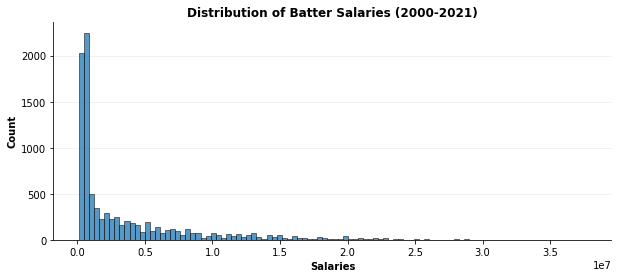

In [161]:
# plot dist of price
fig, ax = plt.subplots(figsize=(10, 4))

sns.histplot(batting_salaries, bins=100)

# removes top and right side axis
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# set gridline visibility
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#EEEEEE')
ax.xaxis.grid(False)

ax.set_xlabel("Salaries", weight = 'bold')
ax.set_ylabel("Count", weight = 'bold')
ax.set_title("Distribution of Batter Salaries (2000-2021)", weight = 'bold')

print('skewness:', skew(batting_salaries))
print('kurtosis:', kurtosis(batting_salaries));

Based on this distribution we can conclude the following:

- The distribution of salaries for batters is highly positively skewed with a long right tail due to outliers.

- Most batters make under $500,000

We will scale the target variable salary using a log function to have a more normalized distribution after we train-test split.

## Train-Test Split

In [162]:
# feature selection, target variable = 'Salary'
X = batting_basic.drop(['Salary'], axis = 1)
y = batting_basic['Salary']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state= 42)

In [163]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(6854, 27)
(2285, 27)
(6854,)
(2285,)


## Define the Preprocessing Pipelines

Steps for preprocessing the data are as follows:

- One hot encode the categorical features; we only have two (2) categoricals: `POS` and `Team`


- Standard Scale the numerical features

In [164]:
# define categorical columns to be OHE
cat_cols = X_train.select_dtypes(['object']).columns

# define numeric columns to be standard scaled
num_cols = X_train.select_dtypes(['int', 'float']).columns

In [166]:
# define numeric transformation pipeline that scales the numbers
numeric_pipeline = Pipeline([('numnorm', StandardScaler())]) # apply a standard scaler

# define a nominal transformation pipeline that OHE the cats, and MaxAbsScales the set
nominal_pipeline = Pipeline([('onehotenc', OneHotEncoder(categories="auto", # ohe the cat variables
                                                         sparse = False))]) 

In [167]:
# transform the selected columns with nominal, and numeric pipelines
bb_ct = ColumnTransformer(transformers = 
                    [("nominalpipe", nominal_pipeline, cat_cols), 
                     ("numpipe", numeric_pipeline, num_cols)])

### Pickle the Transformer

In [168]:
# save the transformer
dump(bb_ct, open('pkl/bb_ct.pkl', 'wb'))

In [169]:
# load the transformer
bb_ct = load(open('pkl/bb_ct.pkl', 'rb'))

In [170]:
# inspect the preprocessed batting basic X train aka pp_bb_X_train
pp_bb_X_train = pd.DataFrame(bb_ct.fit_transform(X_train))
pp_bb_X_train.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.308498,-0.323478,-0.104159,-1.057699,-1.043491,-1.404504,-1.128853,-0.955744,-1.114357,-0.387879,-1.144360,-0.789194,-1.207010,-0.889137,-0.117948,-0.986358,-0.454876,-1.173483,2.080911,-0.520379,-0.100567,-0.099890,-1.326959,-1.965143,-1.878270
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.917267,-0.628117,1.484496,1.922417,1.887449,0.401421,1.774726,2.063652,0.772518,1.835339,0.755409,1.949165,0.936743,1.529448,0.129350,1.637258,0.355763,-1.173483,0.134282,-0.153983,4.315700,2.462968,0.469215,0.062888,0.215500
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.553651,-0.520185,-0.260420,-0.321719,-0.358892,-1.321154,-0.608211,-0.653804,-0.036142,-0.832523,-0.644421,-0.613658,-0.900759,-0.543625,-0.365246,-0.397383,-0.184663,-0.752183,0.523608,-0.153983,-0.565437,-0.099890,-1.375504,-1.106651,-1.286361
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.553651,1.657312,1.093843,1.415677,1.261683,0.679256,1.434307,1.640936,1.042072,-0.387879,0.655421,1.352343,1.072855,-0.241301,-0.117948,0.218364,1.166403,0.511720,0.523608,2.044389,1.061608,-0.099890,-0.089055,0.224633,0.127155
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.553651,-0.542443,0.911538,-0.689709,-0.503300,-0.404299,-0.708335,-0.834968,-0.754952,-0.387879,0.155482,-0.087051,-0.118119,1.097558,0.376647,-0.102895,-0.184663,-1.173483,-0.644370,0.212412,-0.565437,-0.466013,1.901300,0.647658,1.151954


In [171]:
pp_bb_X_train.shape

(6854, 62)

Now lets do the same transformation for the `X_test`

In [145]:
# inspect the preprocessed batting basic X train aka pp_bb_X_test
pp_bb_X_test = pd.DataFrame(bb_ct.transform(X_test))
pp_bb_X_test.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.181808,-0.629358,0.885495,0.854643,0.844505,1.207142,1.093887,1.218221,1.311625,1.835339,-0.444445,0.509771,0.528409,0.147400,0.376647,0.673481,1.436616,3.039525,0.134282,0.578807,1.177826,0.632355,0.711942,0.299285,0.471700
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.308498,0.421647,0.963626,1.439807,1.416787,1.096008,1.634554,2.486367,0.323262,1.835339,-0.844397,1.282129,0.120075,0.967991,-0.612543,-0.343839,-0.725089,-0.330882,2.859563,1.128401,2.223784,3.195213,0.809032,-0.509440,-0.067203
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.289109,-0.014267,-1.510509,-1.087863,-1.096976,0.290287,-0.948631,-0.714192,-0.934654,-0.832523,-1.144360,-1.245587,-1.241038,-1.105082,-0.612543,-1.093444,-0.184663,-0.752183,1.302259,-1.253170,-0.681655,-0.832136,-0.331781,-1.193745,-0.968320
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.672114,-0.112985,0.026059,-0.388078,-0.417725,-1.404504,-0.668285,-0.623610,-0.305696,-0.832523,-0.744409,-0.473230,-0.798676,-0.414058,0.376647,0.111277,-0.454876,-0.330882,-0.644370,-0.703577,0.596738,0.632355,-1.278414,-1.355490,-1.427712
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.308498,-0.649550,-0.182289,-0.442372,-0.465861,-0.376516,-0.508088,-0.261283,-0.934654,-0.832523,-0.444445,-0.789194,-0.458398,-0.414058,0.623945,-0.691870,-0.725089,0.090419,-0.644370,-0.153983,-0.681655,0.632355,-0.525962,-0.770720,-0.729789


In [146]:
pp_bb_X_test.shape

(2285, 62)

For convenience, we'll need to know the names of our columns after preprocessing and the columns or features that are most important during the modeling. 

Below is code to get those feature names after preprocessing the columns.

In [147]:
# check length of each OHE cat features
print(len(X_train['POS'].unique()))
print(len(X_train['Team'].unique()))
print("Total # of Categoricals:", len(X_train['POS'].unique()) + len(X_train['Team'].unique()))

7
30
Total # of Categoricals: 37


In [148]:
# get feature names after encoding
cat_feature_names = list(nominal_pipeline.named_steps['onehotenc'].fit(X_train[cat_cols]).get_feature_names())

# confirm length of feature names
len(cat_feature_names)

/Users/eric/miniforge3/envs/tf_miniforge/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


37

In [149]:
# removes the OHE strings at front end of feature names
def clean_features(lst):
    new_list = []
    for value in lst:
        splitted = value.split('_')[1] # returns name of feature after '_'
        new_list.append(splitted)
        continue
    return new_list

In [150]:
# clean the categorical feature names
cat_feature_names = clean_features(cat_feature_names)

In [151]:
# preview
cat_feature_names[0:10]

['1B', '2B', '3B', 'C', 'OF', 'P', 'SS', 'ARI', 'ATL', 'BAL']

In [152]:
# get numerical feature names
num_features_names = list(num_cols)

In [153]:
# preview
num_features_names[0:10]

['Age', 'Adjusted 2021 Salary', 'G', 'AB', 'PA', 'AVG', 'H', '1B', '2B', '3B']

In [154]:
# put into a dataframe
feature_names_df = pd.DataFrame(cat_feature_names)

# add the numerical cols at end of dataframe
feature_names_df = feature_names_df.append(num_features_names)

/var/folders/m4/85rmk51d0pd2_q6_wp0vplz40000gn/T/ipykernel_9995/638970588.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  feature_names_df = feature_names_df.append(num_features_names)


In [155]:
# check
feature_names_df.tail(20)

,0
5,AVG
6,H
7,1B
8,2B
9,3B
10,HR
11,R
12,RBI
13,BB
14,IBB


**Log Transforming Salary**

As observed earlier, since the target variable salary is not normally distributed, we will want to create a more normalized distribution by log transforming. 

In [55]:
log_y_train = np.log(y_train)
log_y_test = np.log(y_test)

skewness: 0.42535497846509446
kurtosis: -1.1361692432627224


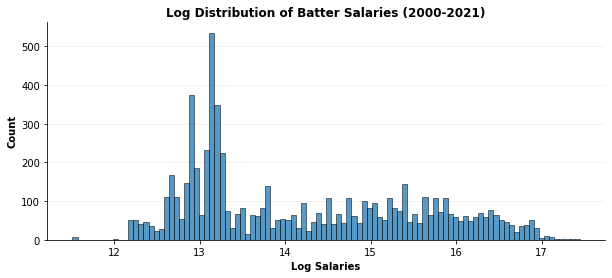

In [57]:
# plot dist of price
fig, ax = plt.subplots(figsize=(10, 4))

sns.histplot(log_y_train, bins=100)

# removes top and right side axis
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# set gridline visibility
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#EEEEEE')
ax.xaxis.grid(False)

ax.set_xlabel("Log Salaries", weight = 'bold')
ax.set_ylabel("Count", weight = 'bold')
ax.set_title("Log Distribution of Batter Salaries (2000-2021)", weight = 'bold')

print('skewness:', skew(log_y_train))
print('kurtosis:', kurtosis(log_y_train));

# Establish Simple Baseline Models

### Metrics

In [58]:
# create function that gives performance metrics
def performance(y_true, y_predict):
    """ 
    Calculates and returns the two performance scores between 
    true and predicted values - first R-Squared, then RMSE
    """

    # Calculate the r2 score between 'y_true' and 'y_predict'
    r2 = r2_score(y_true, y_predict)

    # Calculate the root mean squared error between 'y_true' and 'y_predict'
    rmse = mean_squared_error(np.exp(y_true), np.exp(y_predict), squared = False) # False gives RMSE

    # Return the score
    return [r2, rmse]

### Cross Validation - 5 Folds

In [59]:
# define a simple function that returns cross validation score for a 5 fold
def get_cv_score(model, X, y):
    
    # R2 score CV
    cv_r2_score = np.mean(cross_val_score(model, 
                                       X, y, 
                                       scoring = 'r2', 
                                       cv = 5))
    # RMSE score CV
    cv_rmse_score = np.mean(cross_val_score(model,
                                           X,
                                           np.exp(y),
                                           scoring = 'neg_root_mean_squared_error',
                                           cv = 5))
    
    print(model,"Cross Validation R2:      ",round(cv_r2_score, 4))
    print(model,"Cross Validation RMSE:   ",-round(cv_rmse_score))

### Linear Regression Model

In [60]:
# instantiate the linear regression model
lr_model = LinearRegression()
lr_model

# Fit our model
lr_model.fit(pp_bb_X_train, log_y_train)

# Make predictions on the training and test data
y_pred_train = lr_model.predict(pp_bb_X_train)
y_pred_test = lr_model.predict(pp_bb_X_test)

# Calculate performance using the performance() function 
train_scores = performance(log_y_train, y_pred_train)
test_scores = performance(log_y_test, y_pred_test)

# Training
print(lr_model, 'Training R2:              ', round(train_scores[0],4)) # R2
print(lr_model, 'Test R2:                  ', round(test_scores[0],4)) # R2
print('-----' * 11)
# Validation
get_cv_score(lr_model, pp_bb_X_train, log_y_train)
print('-----' * 11)
# Testing
print(lr_model, 'Training RMSE:           ', round(train_scores[1])) # RMSE
print(lr_model, 'Model Test RMSE:         ', round(test_scores[1])) # RMSE

LinearRegression() Training R2:               0.5373
LinearRegression() Test R2:                   0.5179
-------------------------------------------------------
LinearRegression() Cross Validation R2:       0.5293
LinearRegression() Cross Validation RMSE:    3763551
-------------------------------------------------------
LinearRegression() Training RMSE:            4887787
LinearRegression() Model Test RMSE:          4627395


#### Get Model Results

To streamline the process of getting model results, below is a helper function that performs all the steps above and produces model training, cross validation, and testing results. 

In [61]:
def model_results(model, X_train, y_train, X_test, y_test):
    """
    Helper function that takes input of model, and train-test split sets 
    and returns the model R2, RMSE scores
    """
    # fit the model
    model.fit(X_train, y_train)
    
    # Make predictions on the training and test data
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    # Calculate performance using the performance() function 
    train_scores = performance(y_train, y_pred_train)
    test_scores = performance(y_test, y_pred_test)

    # Training
    print(" "*12, model, "RESULTS")
    print(model, 'Training R2:              ', round(train_scores[0],4)) # R2
    print(model, 'Test R2:                  ', round(test_scores[0],4)) # R2
    print('-----' * 11)
    # Validation
    get_cv_score(model, X_train, y_train)
    print('-----' * 11)
    # Testing
    print(model, 'Training RMSE:           ', round(train_scores[1])) # RMSE
    print(model, 'Test RMSE:               ', round(test_scores[1])) # RMSE

In [62]:
# Test of the model_results function
lr_model = LinearRegression()
model_results(lr_model, pp_bb_X_train, log_y_train, pp_bb_X_test, log_y_test)

             LinearRegression() RESULTS
LinearRegression() Training R2:               0.5373
LinearRegression() Test R2:                   0.5179
-------------------------------------------------------
LinearRegression() Cross Validation R2:       0.5293
LinearRegression() Cross Validation RMSE:    3763551
-------------------------------------------------------
LinearRegression() Training RMSE:            4887787
LinearRegression() Test RMSE:                4627395


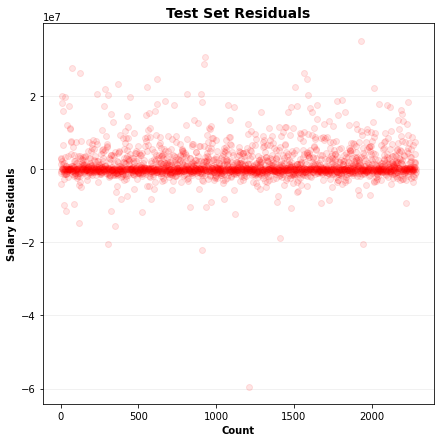

In [63]:
# get residuals plot
resid = y_test - np.exp(y_pred_test)

fig, ax = plt.subplots(figsize=(7, 7))
ax.scatter(x = range(y_pred_test.shape[0]), y = resid, alpha = 0.1, c = 'red')

# residual labels
ax.set_xlabel('Count', weight = 'bold') 
ax.set_ylabel('Salary Residuals', weight = 'bold') 
ax.set_title('Test Set Residuals', weight = 'bold', fontdict = {'fontsize' : 14})

# set gridline visibility
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#EEEEEE')
ax.xaxis.grid(False)

plt.show()

**Pickle the `model_results` function**

In [64]:
# save the helper function
dump(model_results, open('pkl/model_results.pkl', 'wb'))

In [65]:
# load the model results function
get_results = load(open('pkl/model_results.pkl', 'rb'))

In [66]:
get_results(lr_model, pp_bb_X_train, log_y_train, pp_bb_X_test, log_y_test)

             LinearRegression() RESULTS
LinearRegression() Training R2:               0.5373
LinearRegression() Test R2:                   0.5179
-------------------------------------------------------
LinearRegression() Cross Validation R2:       0.5293
LinearRegression() Cross Validation RMSE:    3763551
-------------------------------------------------------
LinearRegression() Training RMSE:            4887787
LinearRegression() Test RMSE:                4627395


**For continued modeling, see Modeling notebooks in the Github Repository**

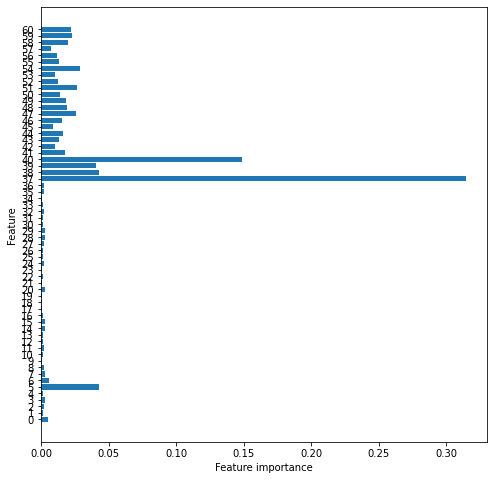

In [41]:
def plot_feature_importances(model):
    n_features = pp_bb_X_train.shape[1]
    plt.figure(figsize=(8,8))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), pp_bb_X_train.columns.values) 
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')

plot_feature_importances(regressor)

In [42]:
pp_bb_X_train

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.615324,-1.277737,-1.320185,-1.278757,-3.256567,-1.315740,-1.280789,-1.271027,-0.729205,-0.941820,-1.214658,-1.213309,-0.991055,-0.532858,-0.847974,-0.571759,-0.969914,2.033278,-1.163921,-0.602031,-0.721621,-2.163013,-2.929161,-2.762856
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-1.101455,-0.639005,-0.457531,-0.488064,-0.088735,-0.494367,-0.198899,-0.764249,-0.729205,-0.941820,-0.690033,-0.790427,-0.573329,-0.270018,-0.671409,-0.291008,-0.545728,-0.330878,-0.621142,0.788319,0.813442,-0.254618,-1.096442,-0.814301
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.372258,0.308081,0.008623,-0.026033,-0.607107,-0.257081,-0.115677,-0.173007,-0.729205,-0.639171,-0.296564,-0.367546,-0.406239,-0.532858,-0.368725,-0.571759,0.302643,1.357805,0.464415,-0.349240,0.429676,-0.820668,-0.907502,-0.913908
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.572267,-0.110399,-0.039600,-0.064138,0.410439,-0.019795,-0.087936,-0.341933,-0.729205,0.773187,-0.067040,0.836040,-0.322694,-0.270018,-0.620962,0.831998,0.302643,-0.668614,0.645342,-0.602031,-0.337856,0.262912,0.972451,0.735828
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.858389,1.233142,1.171330,1.236218,0.160852,0.947600,0.605583,1.178402,-0.252744,1.681132,1.178945,0.998686,1.389981,-0.270018,1.043799,1.955003,1.151015,-0.668614,1.188121,-0.475635,-0.721621,0.521678,0.783511,0.723377
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8563,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.858389,0.968839,0.780189,0.850398,-0.587908,0.308754,-0.115677,1.093939,1.176637,0.571422,0.490375,0.152924,1.306436,-0.007178,1.825732,0.270495,-0.121543,0.344595,-0.621142,0.788319,0.813442,0.052666,0.160009,0.125737
8564,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.858389,-1.211661,-1.255888,-1.235888,-2.488608,-1.260982,-1.225308,-1.186564,-0.729205,-0.941820,-1.181869,-1.148250,-1.074600,-0.532858,-1.125434,-0.852510,-0.969914,2.033278,-0.982995,-0.602031,-0.721621,-2.632025,-2.371788,-2.569868
8565,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.843070,1.034914,0.989155,1.164770,0.103255,0.765073,0.466879,0.418234,-0.252744,2.084663,0.982211,1.909508,2.350750,1.569860,0.892457,0.270495,1.999387,-0.668614,1.369047,-0.349240,-0.721621,0.877480,0.963004,0.972394
8566,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.600004,1.034914,0.555149,0.412183,-0.587908,0.144480,0.133990,-0.004081,-0.252744,0.369656,-0.132618,0.283041,-0.573329,0.255661,0.261866,-0.571759,0.302643,-0.668614,0.464415,-0.602031,-0.721621,-1.095606,-0.265106,-0.596411


(array([  18.,  804., 3014.,  755.,  598.,  919.,  919.,  838.,  583.,
         120.]),
 array([11.51292546, 12.10781596, 12.70270645, 13.29759694, 13.89248743,
        14.48737793, 15.08226842, 15.67715891, 16.2720494 , 16.8669399 ,
        17.46183039]),
 <BarContainer object of 10 artists>)

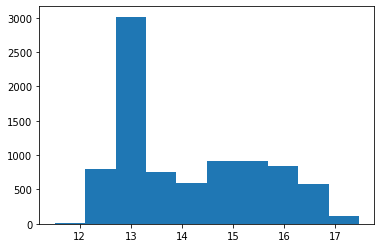

In [43]:
plt.hist(log_y_train)

(array([1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.600e+01, 1.485e+03, 8.510e+02, 5.030e+02]),
 array([ 0.        ,  1.74399998,  3.48799996,  5.23199994,  6.97599992,
         8.7199999 , 10.46399988, 12.20799986, 13.95199984, 15.69599982,
        17.4399998 ]),
 <BarContainer object of 10 artists>)

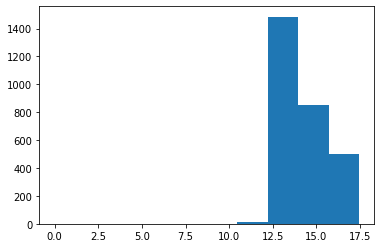

In [44]:
plt.hist(log_y_test)

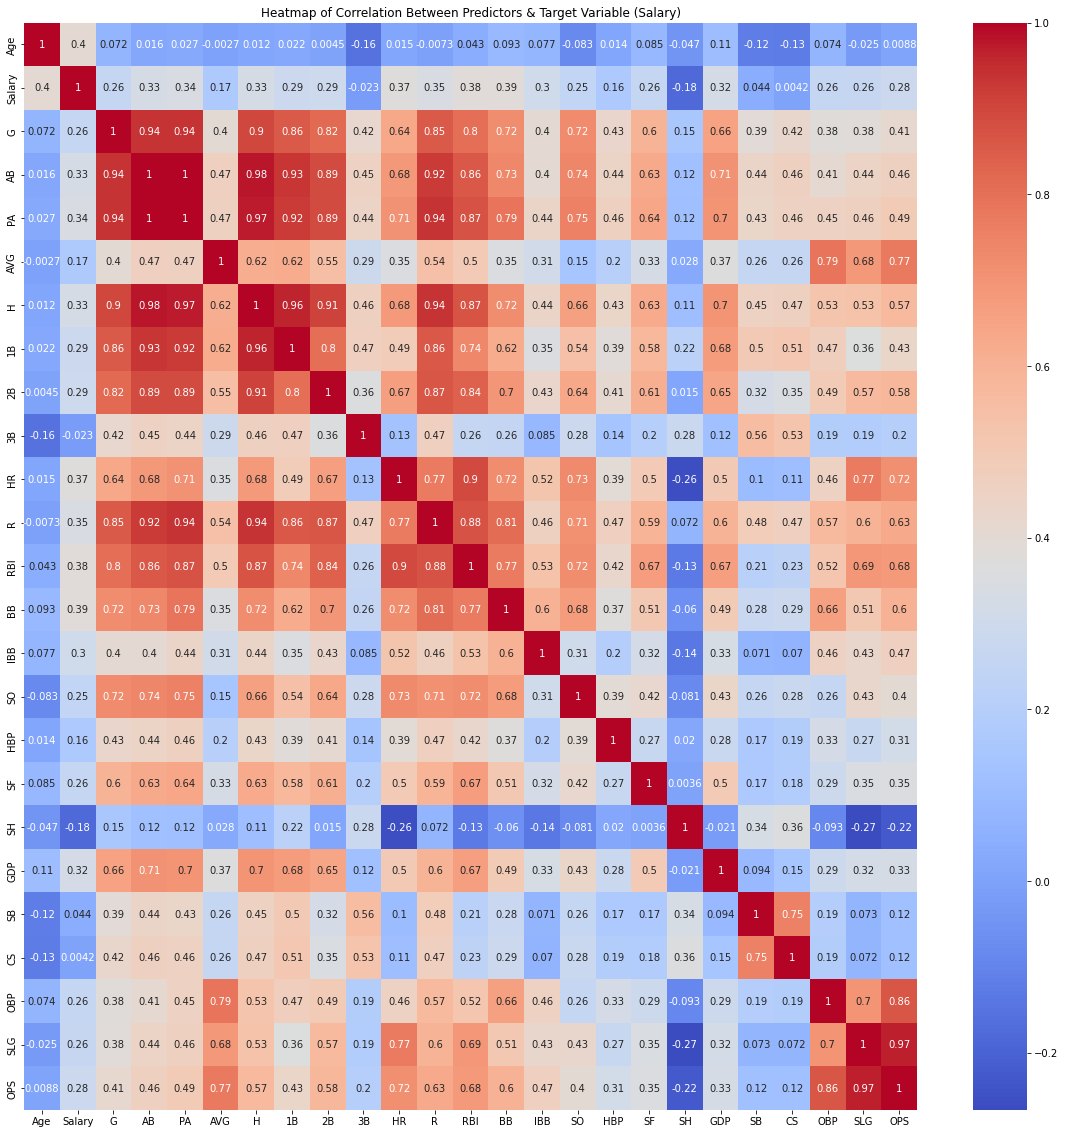

In [67]:
# set up figure size
fig, ax = plt.subplots(figsize=(20, 20))

# set up correlation matrix
corr = batting_basic.corr()

sns.heatmap(corr, cmap = 'coolwarm', annot = True)

# Customize the plot appearance
ax.set_title("Heatmap of Correlation Between Predictors & Target Variable (Salary)");

plt.show()

In [68]:
# instantiate the linear regression model
lr_model = LinearRegression()
lr_model

# Fit our model
lr_model.fit(pp_bb_X_train, y_train)

# Get our R2 score
print('Linear Regression Model R2:', round(lr_model.score(pp_bb_X_train, y_train), 4))
print()

Linear Regression Model R2: 0.4412

